In [1]:
import tqdm as tqdm
from keras.models import *
from keras.layers import *
from keras.layers.convolutional import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils.np_utils import to_categorical
from torchvision.transforms import transforms
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#data processing
def read_and_resize(filename, grayscale = False, fx= 1, fy=1):
    if grayscale:
        img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
        img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    return img_result

#show images
def show_in_row(list_of_images, titles = None, disable_ticks = False):
    count = len(list_of_images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx+1)
        if titles is not None:
            subplot.set_title(titles[idx])

        img = list_of_images[idx]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
        if disable_ticks:
            plt.xticks([]), plt.yticks([])
    plt.show()

#open txt file using path to the file and file_name.txt
def openWithTxt(txt: str, path:str):
    outData = []
    with open("./data/"+txt) as f:
        for i in f.readlines():
            img ,classNum = i.split()
            classNum = int(classNum)
            img = read_and_resize(path+f"{deIdx[classNum]}/"+img).astype("float32")/255
            s = img.shape
            img = cv2.resize(img, (s[0],s[0]), interpolation = cv2.INTER_AREA)
            outData.extend(rotate4sides(img, classNum))
    return np.array(outData)

# takes image ans its classNumber, and produce 4 rotaded images on exact degree (0, 90, 180, 270)
def rotate4sides(image, classNum):
    outData = []
    outData.append(np.array([img, classNum]))
    outData.append(np.array([cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE), classNum]))
    outData.append(np.array([cv2.rotate(img, cv2.ROTATE_180), classNum]))
    outData.append(np.array([cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE), classNum]))
    return outData

In [ ]:
#path = "./data/data/garbage/"
path = "/content/drive/MyDrive/data/data/garbage/"

deIdx = {1:"glass", 2:"paper", 3:"cardboard", 4:"plastic", 5:"metal", 6:"trash"}

testTxt = "one-indexed-files-notrash_test.txt"
trainTxt = "one-indexed-files-notrash_train.txt"
valTxt = "one-indexed-files-notrash_val.txt"

In [4]:
testData = openWithTxt(testTxt, path)
xTest = np.stack(testData[:,0])
yTest =  to_categorical(testData[:,1],num_classes = len(deIdx.values())+1)[:,1:]
print(xTest[0].shape)
testData.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(192, 192, 3)


(862, 2)

In [5]:
trainData = openWithTxt(trainTxt, path)
xTrain = np.stack(trainData[:,0])
yTrain = to_categorical(trainData[:,1],num_classes = len(deIdx.values())+1)[:,1:]
trainData.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(3536, 2)

In [6]:
valData = openWithTxt(valTxt, path)
xVal = np.stack(valData[:,0])
yVal = to_categorical(valData[:,1],num_classes = len(deIdx.values())+1)[:,1:]
valData.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(656, 2)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


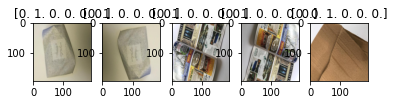

In [7]:
show_in_row(xTest[:5], yTest[:5])

# Model 1

##  CNN (keras)


In [ ]:
img = xVal[0]
imgShape = img.shape
imgShape

# model

In [ ]:
from keras.optimizer_v2.adam import Adam

kernelSize = (3, 3)
model = Sequential()
model.add(Conv2D(32, kernelSize, input_shape=imgShape, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernelSize, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, kernelSize, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, kernelSize, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=3e-4), metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
model.fit(xTrain, yTrain, validation_data=(xVal, yVal), epochs=5, batch_size=512)
model.save_weights("kek.hdf5")
acc = model.evaluate(xTest, yTest)[1]*100
print("Accuracy: &2.f%%" %(acc))

Epoch 1/5


# model pytorch

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
import torchvision.models as models

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(16, 16, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(16, 32, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32 * 18, 128)
        #self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x)



def train(epoch, model, dataTrain, criterion, optimizer ):
    running_loss = 0.0
    model = model.to(torch.device('cuda'))
    model.train()
    for i, data in tqdm(enumerate(dataTrain)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}] loss: {running_loss}')

def test(model, dataTest, criterion):
    model = model.to(torch.device('cuda'))
    model.eval()
    truePos = 0.0
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataTest)):
        inputs, labels = data

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * labels.shape[0]
        truePos += (outputs.argmax(1) == labels.argmax(1)).sum()
    #print(truePos)
    acc = truePos/len(xTest)
    tLoss = running_loss / len(xTest)
    print("acc:",acc, "loss:", tLoss)
    
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    


In [50]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels.argmax(1)).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))
        
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(deIdx.values()))
    
    def forward(self, xb):
        o = self.network(xb)
        return F.softmax(o)



In [24]:
torch.cuda.empty_cache()

In [51]:
from torch.utils.data import Dataset
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device, len):
        self.dl = dl
        self.device = device
        self.len = len
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return self.len

class MyData(Dataset):
    def __init__(self, x, y, transform):
        self.x = x
        self.y = y
        self.transform = transform
        self.len = len(x)
        self.to_tensor = transforms.ToTensor()
    def __len__(self):
        return self.len
    def __getitem__(self, item):
        #print(type(self.x[item]))
        return self.transform(self.x[item]), torch.from_numpy(self.y[item])

device = get_default_device()
device

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
batch_size = 32

myDataTrain = MyData(xTrain,yTrain, transform)
myDataVal = MyData(xVal,yVal, transform)
myDataTest = MyData(xTest,yTest, transform)

dataTrain = torch.utils.data.DataLoader(myDataTrain, batch_size=batch_size)
dataVal = torch.utils.data.DataLoader(myDataVal, batch_size=batch_size)
dataTest = torch.utils.data.DataLoader(myDataTest, batch_size=batch_size)

dataTrain = DeviceDataLoader(dataTrain, device,len(dataTrain ))
dataVal = DeviceDataLoader(dataVal, device,len(dataVal ))
dataTest = DeviceDataLoader(dataTest, device,len(dataTest ))

In [52]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [53]:
model = to_device(ResNet(), device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
evaluate(model, dataTest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


{'val_loss': 1.1175850629806519, 'val_acc': 0.9305555820465088}

In [55]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 5.5e-5 

history = fit(num_epochs, lr, model, dataTrain, dataVal, opt_func)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1: train_loss: 1.3832, val_loss: 1.1967, val_acc: 0.8646
Epoch 2: train_loss: 1.1769, val_loss: 1.1631, val_acc: 0.8884
Epoch 3: train_loss: 1.1358, val_loss: 1.1649, val_acc: 0.8765
Epoch 4: train_loss: 1.1161, val_loss: 1.1287, val_acc: 0.9196
Epoch 5: train_loss: 1.0865, val_loss: 1.1322, val_acc: 0.9182
Epoch 6: train_loss: 1.0730, val_loss: 1.1171, val_acc: 0.9301
Epoch 7: train_loss: 1.0656, val_loss: 1.1307, val_acc: 0.9167
Epoch 8: train_loss: 1.0607, val_loss: 1.1123, val_acc: 0.9345
Epoch 9: train_loss: 1.0567, val_loss: 1.1031, val_acc: 0.9435
Epoch 10: train_loss: 1.0576, val_loss: 1.1107, val_acc: 0.9330


In [12]:
ep = 25
model = ResNet()
model.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

for i in range(ep):
    train(i, model, dataTrain, criterion, optimizer)
    test(model, dataVal, criterion)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
111it [00:29,  3.79it/s]


[1] loss: 186.7295023202896


21it [00:01, 12.45it/s]


acc: tensor(0.2042, device='cuda:0') loss: 1.275809445126704


111it [00:28,  3.92it/s]


[2] loss: 183.63887631893158


21it [00:01, 12.28it/s]


acc: tensor(0.1729, device='cuda:0') loss: 1.2404472855570146


111it [00:29,  3.77it/s]


[3] loss: 181.67684757709503


21it [00:01, 12.39it/s]


acc: tensor(0.1775, device='cuda:0') loss: 1.2457402244797993


111it [00:28,  3.93it/s]


[4] loss: 183.04567575454712


21it [00:01, 12.40it/s]


acc: tensor(0.1647, device='cuda:0') loss: 1.2496655944328574


111it [00:28,  3.92it/s]


[5] loss: 182.05628538131714


21it [00:01, 12.44it/s]


acc: tensor(0.1763, device='cuda:0') loss: 1.2516627920199437


111it [00:28,  3.92it/s]


[6] loss: 181.48108172416687


21it [00:01, 12.44it/s]


acc: tensor(0.1520, device='cuda:0') loss: 1.245338227522069


111it [00:28,  3.92it/s]


[7] loss: 181.78029608726501


21it [00:01, 12.38it/s]


acc: tensor(0.1601, device='cuda:0') loss: 1.2505887157679156


24it [00:06,  3.82it/s]


KeyboardInterrupt: ignored

In [34]:
test(model, dataTrain, criterion)

111it [00:09, 11.83it/s]

acc: tensor(4.0661, device='cuda:0') loss: 4.317393862730943


In [ ]:
accuracy(model(list(dataTest)[0][0]).argmax(1), list(dataTest)[0][1].argmax(1))

In [34]:
list(dataTest)[0][1].argmax(1)

tensor([1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 3, 3, 2, 2, 4, 4,
        0, 0, 1, 1, 2, 2, 3, 3, 2, 2, 1, 1, 1, 1, 2, 2, 0, 0, 5, 5, 3, 3, 2, 2,
        3, 3, 4, 4, 4, 4, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 1, 1, 2, 2,
        3, 3, 0, 0, 1, 1, 0, 0, 2, 2, 5, 5, 5, 5, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 0, 0, 5, 5, 4, 4, 4, 4, 2, 2, 3, 3,
        1, 1, 1, 1, 3, 3, 3, 3], device='cuda:0')

In [35]:
model(list(dataTest)[0][0]).argmax(1)

TypeError: ignored

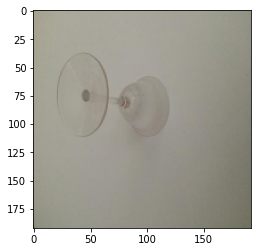

In [57]:
show_in_row([xTest[6]])

In [ ]:
deIdx

{1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}

In [65]:
tIdx = 6 
labelTrue = yTest[tIdx]


In [63]:
model(torch.tensor(xTest[6].transpose([2,0,1])).unsqueeze(0).to(device))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[9.9920e-01, 3.7047e-04, 5.8046e-05, 3.0478e-04, 1.1301e-05, 5.7821e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

array([[[0.6421569 , 0.6303922 , 0.55588233],
        [0.63725495, 0.6254902 , 0.55098045],
        [0.63823533, 0.6264706 , 0.5519608 ],
        ...,
        [0.5715686 , 0.57549024, 0.5137255 ],
        [0.5686275 , 0.57254905, 0.5019608 ],
        [0.5627451 , 0.5666667 , 0.49607843]],

       [[0.63823533, 0.6264706 , 0.5519608 ],
        [0.64705884, 0.63529414, 0.56078434],
        [0.63823533, 0.6264706 , 0.5519608 ],
        ...,
        [0.5627451 , 0.5666667 , 0.5019608 ],
        [0.5686275 , 0.57254905, 0.5019608 ],
        [0.57450986, 0.5784314 , 0.50784314]],

       [[0.6362745 , 0.6245098 , 0.55      ],
        [0.6529412 , 0.64117646, 0.5666667 ],
        [0.64607847, 0.63431376, 0.55980396],
        ...,
        [0.5627451 , 0.5666667 , 0.5019608 ],
        [0.5686275 , 0.57254905, 0.5019608 ],
        [0.57450986, 0.5784314 , 0.50784314]],

       ...,

       [[0.4764706 , 0.48431373, 0.3882353 ],
        [0.5529412 , 0.56078434, 0.4745098 ],
        [0.5588236 , 0